In [ ]:
# Environment Setup and Data Loading
from google.colab import drive
import os
import zipfile
import shutil
import time
import torch
import numpy as np
import random
import pandas as pd
import glob
from collections import Counter

drive.mount('/content/drive')

os.makedirs('/content/celeba_data', exist_ok=True)
os.chdir('/content/celeba_data')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

print(f"GPU: {torch.cuda.get_device_name()}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Mounted at /content/drive
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


In [ ]:
# Extract and organize CelebA dataset
archive_path = '/content/drive/MyDrive/archive.zip'

if os.path.exists(archive_path):
    print("Copying archive from Drive...")
    shutil.copy2(archive_path, '/content/celeba_data/archive.zip')

    print("Extracting archive...")
    start_time = time.time()

    with zipfile.ZipFile('/content/celeba_data/archive.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/celeba_data/')

    extract_time = time.time() - start_time
    print(f"Extraction completed in {extract_time/60:.1f} minutes")

    os.remove('/content/celeba_data/archive.zip')
    print("Removed zip file")
else:
    print(f"Archive not found at: {archive_path}")
    print("Update the path in the code")

Copying archive from Drive...
Extracting archive...
Extraction completed in 0.8 minutes
Removed zip file


In [ ]:
# Initialize paths
from pathlib import Path
import os

ROOT = Path("/content/celeba_data/archive")
IMG_DIR   = ROOT / "img_align_celeba"
ID_FILE   = ROOT / "identity_CelebA.txt"
PART_FILE = ROOT / "list_eval_partition.csv"

print("ROOT:", ROOT, "exists:", ROOT.exists())
print("IMG_DIR:", IMG_DIR,   "exists:", IMG_DIR.exists())
print("ID_FILE:", ID_FILE,   "exists:", ID_FILE.exists())
print("PART_FILE:", PART_FILE, "exists:", PART_FILE.exists())

jpg_count = len(list(IMG_DIR.glob("*.jpg"))) if IMG_DIR.exists() else 0
print("Total JPGs visible in IMG_DIR:", jpg_count)

ROOT: /content/celeba_data/archive exists: True
IMG_DIR: /content/celeba_data/archive/img_align_celeba exists: True
ID_FILE: /content/celeba_data/archive/identity_CelebA.txt exists: True
PART_FILE: /content/celeba_data/archive/list_eval_partition.csv exists: True
Total JPGs visible in IMG_DIR: 202599


In [ ]:
# Split the data
import pandas as pd
import numpy as np
from pathlib import Path

rng = np.random.default_rng(42)

identities = pd.read_csv(ID_FILE, sep=r"\s+", header=None,
                         names=["image_id","celebrity_id"])

def with_existing_files(frame, img_dir):
    m = frame["image_id"].apply(lambda fn: (IMG_DIR/fn).exists())
    miss = (~m).sum()
    if miss: print(f"Filtered out {miss} rows with missing images")
    return frame[m].copy()

df = with_existing_files(identities, IMG_DIR)

MIN_TOTAL = 12
per_id = df["celebrity_id"].value_counts()
keep_ids = per_id[per_id >= MIN_TOTAL].index
df = df[df["celebrity_id"].isin(keep_ids)].copy()

K = None
if K is not None:
    top_ids = per_id.loc[keep_ids].sort_values(ascending=False).head(K).index
    df = df[df["celebrity_id"].isin(top_ids)].copy()

VAL_FRAC, TEST_FRAC = 0.10, 0.10
MIN_VAL, MIN_TEST   = 1, 1
MIN_TRAIN           = 5

parts = []
for cid, g in df.groupby("celebrity_id", sort=False):
    idx = np.arange(len(g))
    rng.shuffle(idx)

    n = len(idx)
    n_val  = max(MIN_VAL,  int(round(n * VAL_FRAC)))
    n_test = max(MIN_TEST, int(round(n * TEST_FRAC)))
    if n - (n_val + n_test) < MIN_TRAIN:
        spare = max(0, n - MIN_TRAIN)
        n_val = min(n_val, spare // 2)
        n_test = min(n_test, spare - n_val)

    val_idx  = idx[:n_val]
    test_idx = idx[n_val:n_val+n_test]
    train_idx= idx[n_val+n_test:]

    g_np = g.reset_index(drop=True)
    parts.append(
        pd.DataFrame({
            "image_id": g_np.loc[train_idx, "image_id"], "celebrity_id": cid, "split": "train"
        })
    )
    parts.append(
        pd.DataFrame({
            "image_id": g_np.loc[val_idx, "image_id"], "celebrity_id": cid, "split": "valid"
        })
    )
    parts.append(
        pd.DataFrame({
            "image_id": g_np.loc[test_idx, "image_id"], "celebrity_id": cid, "split": "test"
        })
    )

df_split = pd.concat(parts, ignore_index=True)

train_df = df_split[df_split["split"]=="train"].copy()
valid_df = df_split[df_split["split"]=="valid"].copy()
test_df  = df_split[df_split["split"]=="test"].copy()

train_ids = np.sort(train_df["celebrity_id"].unique())
id2idx = {cid:i for i,cid in enumerate(train_ids)}

train_df["label"] = train_df["celebrity_id"].map(id2idx).astype(int)
valid_df = valid_df[valid_df["celebrity_id"].isin(train_ids)].copy()
test_df  = test_df [test_df ["celebrity_id"].isin(train_ids)].copy()
valid_df["label"] = valid_df["celebrity_id"].map(id2idx).astype(int)
test_df["label"]  = test_df["celebrity_id"].map(id2idx).astype(int)

NUM_CLASSES = len(id2idx)

print("Classes (NUM_CLASSES):", NUM_CLASSES)
print("Images | train:", len(train_df), " valid:", len(valid_df), " test:", len(test_df))
print("Per-class train stats:\n", train_df["label"].value_counts().describe())


Classes (NUM_CLASSES): 7968
Images | train: 151984  valid: 18688  test: 18688
Per-class train stats:
 count    7968.000000
mean       19.074297
std         4.432414
min        10.000000
25%        16.000000
50%        19.000000
75%        24.000000
max        28.000000
Name: count, dtype: float64


In [ ]:
import numpy as np, pandas as pd

K = 5000
QUOTA_TR = 15
QUOTA_VA = 4
QUOTA_TE = 5
totals = (pd.concat([train_df[['celebrity_id']],
                     valid_df[['celebrity_id']],
                     test_df [['celebrity_id']]])
          .value_counts().rename('count'))
ranked_ids = totals.index.get_level_values(0).to_numpy()
keep_ids = set(ranked_ids[:K]) if (K is not None and K < len(ranked_ids)) else set(ranked_ids)

train_df = train_df[train_df['celebrity_id'].isin(keep_ids)].copy()
valid_df = valid_df[valid_df['celebrity_id'].isin(keep_ids)].copy()
test_df  = test_df [test_df ['celebrity_id'].isin(keep_ids)].copy()

def cap_group(g, n, seed=42):
    return g if len(g) <= n else g.sample(n=n, random_state=seed)

train_df = (train_df.groupby('celebrity_id', group_keys=False)
                     .apply(lambda g: cap_group(g, QUOTA_TR)).reset_index(drop=True))
valid_df = (valid_df.groupby('celebrity_id', group_keys=False)
                     .apply(lambda g: cap_group(g, QUOTA_VA)).reset_index(drop=True))
test_df  = (test_df .groupby('celebrity_id', group_keys=False)
                     .apply(lambda g: cap_group(g, QUOTA_TE)).reset_index(drop=True))

ids = np.sort(train_df['celebrity_id'].unique())
id2idx = {cid:i for i,cid in enumerate(ids)}
train_df['label'] = train_df['celebrity_id'].map(id2idx).astype(int)
valid_df = valid_df[valid_df['celebrity_id'].isin(ids)].copy()
test_df  = test_df [test_df ['celebrity_id'].isin(ids)].copy()
valid_df['label'] = valid_df['celebrity_id'].map(id2idx).astype(int)
test_df ['label'] = test_df ['celebrity_id'].map(id2idx).astype(int)
NUM_CLASSES = len(id2idx)

print("Classes:", NUM_CLASSES,
      "| train:", len(train_df), "valid:", len(valid_df), "test:", len(test_df))
print("Per-class train counts (min/mean/max):",
      train_df['label'].value_counts().min(),
      train_df['label'].value_counts().mean(),
      train_df['label'].value_counts().max())

/tmp/ipython-input-2158502913.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: cap_group(g, QUOTA_TR)).reset_index(drop=True))
/tmp/ipython-input-2158502913.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: cap_group(g, QUOTA_VA)).reset_index(drop=True))


Classes: 5000 | train: 75000 valid: 13303 test: 13303
Per-class train counts (min/mean/max): 15 15.0 15


/tmp/ipython-input-2158502913.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: cap_group(g, QUOTA_TE)).reset_index(drop=True))


In [ ]:
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CelebAID(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.tfm = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(self.img_dir / r.image_id).convert('RGB')
        x = self.tfm(img)
        y = torch.tensor(r.label, dtype=torch.long)
        return {'image': x, 'label': y}

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = CelebAID(train_df, IMG_DIR, train_tfms)
valid_ds = CelebAID(valid_df, IMG_DIR, test_tfms)
test_ds  = CelebAID(test_df,  IMG_DIR, test_tfms)


In [ ]:
import math, torch, torch.nn as nn, torch.nn.functional as F, timm


class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5, easy_margin=False):
        super().__init__()
        self.s, self.m = s, m
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin

    def forward(self, emb, labels=None):
        W = F.normalize(self.weight)
        x = F.normalize(emb)
        cosine = F.linear(x, W)

        if labels is None:
            return self.s * cosine

        cos_m = math.cos(self.m); sin_m = math.sin(self.m)
        th    = math.cos(math.pi - self.m)
        mm    = math.sin(math.pi - self.m) * self.m

        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, 0, 1))
        phi  = cosine * cos_m - sine * sin_m
        phi  = torch.where(cosine > th, phi, cosine - mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        return self.s * logits



class ArcFaceClassifier(nn.Module):
    def __init__(self, name, num_classes, dropout=0.0, s=64.0, m=0.5):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features
        self.bn = nn.BatchNorm1d(feat_dim)
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.head = ArcMarginProduct(feat_dim, num_classes, s=s, m=m)
    def forward(self, x, labels=None):
        feat = self.backbone(x)
        feat = self.bn(feat)
        feat = self.drop(feat)
        return self.head(feat, labels)

In [ ]:
# DataLoaders
from torch.utils.data import DataLoader
import torch

BATCH = 64 if torch.cuda.is_available() else 16
NUM_WORKERS = 2 if torch.cuda.is_available() else 0
PIN = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)

In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast as autocast_cuda
from torch.cuda.amp import GradScaler

AMP_ON = torch.cuda.is_available()
DEVICE = torch.device('cuda' if AMP_ON else 'cpu')

hist = train_df['label'].value_counts().sort_index().values
priors = torch.tensor(hist / hist.sum(), device=DEVICE).clamp_min(1e-12)
log_priors = priors.log()

def balanced_ce(logits, targets):
    return F.cross_entropy(logits + log_priors, targets, label_smoothing=0.1)

USE_ARCFACE = True

def arcface_ce(logits, targets):
    return F.cross_entropy(logits, targets)

def softmax_balanced_ce(logits, targets):
    return F.cross_entropy(logits + log_priors, targets, label_smoothing=0.1)

def criterion_fn(logits, targets):
    return arcface_ce(logits, targets) if USE_ARCFACE else softmax_balanced_ce(logits, targets)


scaler = GradScaler(enabled=AMP_ON)

/tmp/ipython-input-3678718978.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=AMP_ON)


In [ ]:
import timm
import torch.nn as nn

class TimmClassifier(nn.Module):
    def __init__(self, name, num_classes, dropout=0.2):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
        f = self.backbone.num_features
        self.head = nn.Sequential(
            nn.LayerNorm(f),
            nn.Dropout(dropout),
            nn.Linear(f, num_classes)
        )
    def forward(self, x, labels=None):
        feats = self.backbone(x)
        return self.head(feats)


In [ ]:
from torch.cuda.amp import autocast as autocast_cuda

import torch.optim as optim

def build_optim(model):
    if USE_ARCFACE:
        back_params, head_params = [], []
        for n,p in model.named_parameters():
            if not p.requires_grad:
                continue
            if n.startswith("bn") or n.startswith("head."):
                head_params.append(p)
            else:
                head_params.append(p) if "head." in n else back_params.append(p)
        return optim.AdamW(
            [
              {"params": back_params, "lr": 1e-4, "weight_decay": 1e-4},
              {"params": head_params, "lr": 5e-4, "weight_decay": 0.0},
            ]
        )
    else:
        return optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

from torch.cuda.amp import autocast as autocast_cuda

def train_one_epoch(model, loader, optimizer):
    model.train(); n=0; tl=0; t1=0; t5=0
    for b in loader:
        x = b['image'].to(DEVICE, non_blocking=True)
        y = b['label'].to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast_cuda(enabled=AMP_ON):
            logits_train = model(x, y) if USE_ARCFACE else model(x)
            loss = criterion_fn(logits_train, y)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()

        with torch.no_grad():
            logits_eval = model(x, None) if USE_ARCFACE else logits_train

        bs = x.size(0); n += bs
        tl += loss.item() * bs
        t1 += (logits_eval.argmax(1) == y).float().sum().item()
        t5 += (logits_eval.topk(5, dim=1).indices.eq(y.view(-1,1))).any(dim=1).float().sum().item()
    return tl/n, t1/n, t5/n

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); n=0; tl=0; t1=0; t5=0
    for b in loader:
        x = b['image'].to(DEVICE); y = b['label'].to(DEVICE)
        with autocast_cuda(enabled=AMP_ON):
            if USE_ARCFACE:
                logits_train = model(x, y)
                logits_eval  = model(x, None)
                loss = F.cross_entropy(logits_train, y)
            else:
                logits_eval = model(x)
                loss = softmax_balanced_ce(logits_eval, y)
        bs = x.size(0); n += bs
        tl += loss.item() * bs
        t1 += (logits_eval.argmax(1) == y).float().sum().item()
        t5 += (logits_eval.topk(5, dim=1).indices.eq(y.view(-1,1))).any(dim=1).float().sum().item()
    return tl/n, t1/n, t5/n

@torch.no_grad()
def test_topk(model, loader, ks=(1,5)):
    model.eval(); hits = {k:0 for k in ks}; n=0
    for b in loader:
        x = b['image'].to(DEVICE); y = b['label'].to(DEVICE)
        logits = model(x, None) if USE_ARCFACE else model(x)
        n += x.size(0)
        for k in ks:
            topk = logits.topk(k, dim=1).indices
            hits[k] += (topk.eq(y.view(-1,1))).any(dim=1).float().sum().item()
    return {f"top{k}": round(100.0*hits[k]/n, 2) for k in ks}

M_START, M_END = 0.15, 0.50

def set_margin(model, frac):
    if hasattr(model, "head") and hasattr(model.head, "m"):
        model.head.m = M_START + (M_END - M_START) * frac


In [ ]:
import time
import pandas as pd
import torch.optim as optim
from pathlib import Path

USE_ARCFACE = True
TEST_EACH_EPOCH = True

def build_model(name, num_classes, dropout):
    cls = ArcFaceClassifier if USE_ARCFACE else TimmClassifier
    return cls(name, num_classes, dropout).to(device)

BACKBONES = [
    ("tf_efficientnet_b3_ns", 0.2),
    ("tf_efficientnet_b4_ns", 0.2),
    ("resnet50",              0.1),
    ("convnext_base",         0.2),
]

EPOCHS   = 15
LR       = 3e-4
WD       = 1e-4
PATIENCE = 5
save_dir = Path('/content/ckpts'); save_dir.mkdir(parents=True, exist_ok=True)

summary_rows = []
epoch_rows   = []

for name, drop in BACKBONES:
    print(f"\n=== Training {name} ({'ArcFace' if USE_ARCFACE else 'Softmax'}) ===")
    model = build_model(name, NUM_CLASSES, drop)
    opt = build_optim(model)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    best_val = 0.0
    patience = PATIENCE
    best_path = save_dir / f"best_{name.replace('.', '_')}.pth"

    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        if USE_ARCFACE:
            set_margin(model, frac=(epoch-1)/(EPOCHS-1))

        tr_l, tr_t1, tr_t5 = train_one_epoch(model, train_loader, opt)
        va_l, va_t1, va_t5 = evaluate(model, valid_loader)

        te_t1 = te_t5 = None
        if TEST_EACH_EPOCH:
            te = test_topk(model, test_loader, ks=(1,5))
            te_t1, te_t5 = te["top1"], te["top5"]

        sch.step()
        secs = time.time() - t0

        msg = (f"[{epoch:02d}/{EPOCHS}] {secs:5.1f}s | "
               f"train L {tr_l:.4f}  T1 {tr_t1*100:5.2f}%  T5 {tr_t5*100:5.2f}%   ||   "
               f"val L {va_l:.4f}  T1 {va_t1*100:5.2f}%  T5 {va_t5*100:5.2f}%")
        if TEST_EACH_EPOCH:
            msg += f"   ||   test T1 {te_t1:5.2f}%  T5 {te_t5:5.2f}%"
        print(msg)

        row = {
            "Model": name, "Epoch": epoch, "Seconds": round(secs,1),
            "Train Loss": tr_l, "Train Top-1 (%)": tr_t1*100, "Train Top-5 (%)": tr_t5*100,
            "Val Loss": va_l,   "Val Top-1 (%)": va_t1*100,   "Val Top-5 (%)": va_t5*100
        }
        if TEST_EACH_EPOCH:
            row["Test Top-1 (%)"] = te_t1
            row["Test Top-5 (%)"] = te_t5
        epoch_rows.append(row)

        if va_t1 > best_val:
            best_val = va_t1
            torch.save(model.state_dict(), best_path)
            patience = PATIENCE
            print("   ↳ saved best")
        else:
            patience -= 1
            if patience == 0:
                print("   ↳ early stop")
                break

    best = build_model(name, NUM_CLASSES, drop)
    best.load_state_dict(torch.load(best_path, map_location=device), strict=True)
    test_metrics = test_topk(best, test_loader, ks=(1,5))

    summary_rows.append({
        "Model": name,
        "Val Top-1 (%)":  round(best_val*100, 2),
        "Test Top-1 (%)": test_metrics["top1"],
        "Test Top-5 (%)": test_metrics["top5"],
        "Checkpoint": str(best_path)
    })

RESULTS_SUMMARY = pd.DataFrame(summary_rows).sort_values("Test Top-1 (%)", ascending=False).reset_index(drop=True)
EPOCH_LOGS      = pd.DataFrame(epoch_rows)



=== Training tf_efficientnet_b3_ns (ArcFace) ===


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipython-input-1575705938.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cuda(enabled=AMP_ON):
/tmp/ipython-input-1575705938.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cuda(enabled=AMP_ON):


[01/15] 344.6s | train L 16.5601  T1 12.72%  T5 22.93%   ||   val L 13.2881  T1 27.69%  T5 45.92%   ||   test T1 27.35%  T5 45.49%
   ↳ saved best
[02/15] 193.1s | train L 11.7476  T1 64.54%  T5 80.28%   ||   val L 10.7463  T1 59.60%  T5 74.71%   ||   test T1 59.06%  T5 74.25%
   ↳ saved best
[03/15] 193.0s | train L 8.9383  T1 87.83%  T5 94.81%   ||   val L 10.3339  T1 68.78%  T5 81.53%   ||   test T1 68.41%  T5 81.40%
   ↳ saved best
[04/15] 195.1s | train L 7.9987  T1 93.08%  T5 97.11%   ||   val L 10.2784  T1 74.72%  T5 85.30%   ||   test T1 74.16%  T5 85.09%
   ↳ saved best
[05/15] 193.7s | train L 7.6225  T1 95.83%  T5 98.15%   ||   val L 10.7612  T1 77.19%  T5 86.74%   ||   test T1 76.73%  T5 86.74%
   ↳ saved best
[06/15] 194.8s | train L 7.8859  T1 96.61%  T5 98.43%   ||   val L 11.3130  T1 79.22%  T5 88.28%   ||   test T1 78.76%  T5 87.98%
   ↳ saved best
[07/15] 194.1s | train L 8.2074  T1 97.22%  T5 98.65%   ||   val L 12.0221  T1 80.54%  T5 89.22%   ||   test T1 80.12%  T5

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

[01/15] 339.3s | train L 16.2349  T1 17.15%  T5 28.61%   ||   val L 12.6729  T1 32.24%  T5 51.09%   ||   test T1 32.15%  T5 50.72%
   ↳ saved best
[02/15] 220.8s | train L 10.8350  T1 71.37%  T5 84.85%   ||   val L 9.5170  T1 65.93%  T5 79.58%   ||   test T1 65.03%  T5 79.64%
   ↳ saved best
[03/15] 223.3s | train L 7.5361  T1 91.47%  T5 96.54%   ||   val L 8.9543  T1 74.33%  T5 85.48%   ||   test T1 73.68%  T5 85.50%
   ↳ saved best
[04/15] 222.2s | train L 6.4753  T1 95.36%  T5 97.98%   ||   val L 8.7141  T1 79.78%  T5 88.81%   ||   test T1 78.78%  T5 88.41%
   ↳ saved best
[05/15] 221.8s | train L 5.8176  T1 97.27%  T5 98.76%   ||   val L 9.0874  T1 81.79%  T5 89.75%   ||   test T1 81.31%  T5 89.71%
   ↳ saved best
[06/15] 221.4s | train L 5.6752  T1 97.97%  T5 99.01%   ||   val L 9.6193  T1 83.09%  T5 90.82%   ||   test T1 82.82%  T5 90.73%
   ↳ saved best
[07/15] 222.0s | train L 5.9518  T1 98.29%  T5 99.14%   ||   val L 10.3014  T1 84.36%  T5 91.30%   ||   test T1 83.85%  T5 91.1

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[01/15] 222.7s | train L 17.1247  T1  8.73%  T5 16.96%   ||   val L 15.0087  T1 15.12%  T5 28.05%   ||   test T1 15.46%  T5 27.92%
   ↳ saved best
[02/15] 194.4s | train L 13.8994  T1 52.62%  T5 71.06%   ||   val L 14.1631  T1 37.50%  T5 53.90%   ||   test T1 37.04%  T5 53.91%
   ↳ saved best
[03/15] 193.1s | train L 12.2500  T1 79.87%  T5 91.04%   ||   val L 14.3439  T1 47.70%  T5 63.61%   ||   test T1 46.83%  T5 63.35%
   ↳ saved best
[04/15] 192.6s | train L 11.7493  T1 88.07%  T5 95.32%   ||   val L 14.7497  T1 55.21%  T5 69.98%   ||   test T1 54.54%  T5 69.78%
   ↳ saved best
[05/15] 192.9s | train L 11.7121  T1 92.49%  T5 97.23%   ||   val L 15.4138  T1 58.87%  T5 73.79%   ||   test T1 58.80%  T5 73.65%
   ↳ saved best
[06/15] 193.3s | train L 11.9370  T1 94.60%  T5 98.01%   ||   val L 16.3154  T1 62.12%  T5 76.02%   ||   test T1 61.99%  T5 75.67%
   ↳ saved best
[07/15] 194.7s | train L 12.6857  T1 95.37%  T5 98.23%   ||   val L 17.2999  T1 64.48%  T5 77.83%   ||   test T1 64.11

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

[01/15] 441.9s | train L 15.2641  T1 20.76%  T5 34.83%   ||   val L 11.2136  T1 44.37%  T5 64.56%   ||   test T1 43.42%  T5 64.36%
   ↳ saved best
[02/15] 359.8s | train L 9.6488  T1 74.86%  T5 87.73%   ||   val L 7.9695  T1 74.85%  T5 86.83%   ||   test T1 74.68%  T5 86.54%
   ↳ saved best
[03/15] 361.1s | train L 6.6635  T1 91.97%  T5 96.51%   ||   val L 7.3398  T1 81.51%  T5 90.75%   ||   test T1 81.06%  T5 90.72%
   ↳ saved best
[04/15] 359.7s | train L 5.7423  T1 95.37%  T5 97.84%   ||   val L 7.0533  T1 85.81%  T5 92.65%   ||   test T1 85.16%  T5 92.63%
   ↳ saved best
[05/15] 359.6s | train L 5.2073  T1 96.75%  T5 98.36%   ||   val L 7.1251  T1 87.59%  T5 93.91%   ||   test T1 87.60%  T5 93.73%
   ↳ saved best
[06/15] 359.7s | train L 5.4140  T1 97.28%  T5 98.45%   ||   val L 7.2451  T1 89.28%  T5 94.58%   ||   test T1 89.05%  T5 94.44%
   ↳ saved best
[07/15] 360.1s | train L 4.9067  T1 97.82%  T5 98.72%   ||   val L 7.2409  T1 91.06%  T5 95.44%   ||   test T1 90.69%  T5 94.99%

In [ ]:
print("\n Model Comparison (Val/Test)")
print(RESULTS_SUMMARY[["Model","Val Top-1 (%)","Test Top-1 (%)","Test Top-5 (%)"]]
      .to_string(index=False))


 Model Comparison (Val/Test)
                Model  Val Top-1 (%)  Test Top-1 (%)  Test Top-5 (%)
        convnext_base          92.89           92.36           96.05
tf_efficientnet_b4_ns          86.23           86.03           92.53
tf_efficientnet_b3_ns          85.11           84.80           92.09
             resnet50          68.04           67.77           80.40


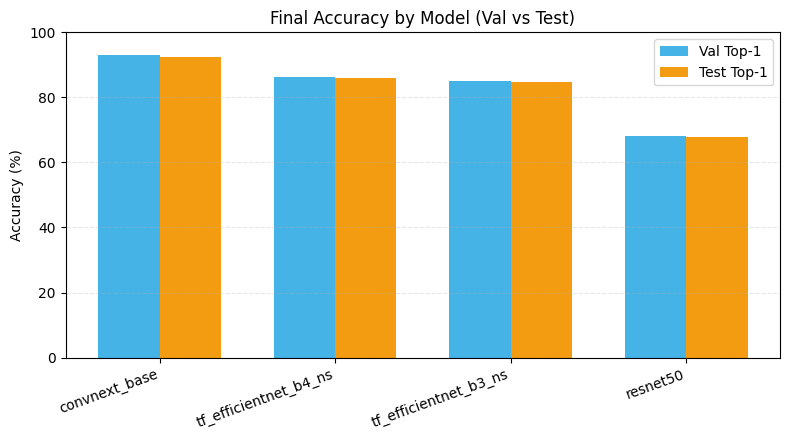

Saved: /content/celeba_data/visualization_graphs/bar_final_val_vs_test_by_model.png


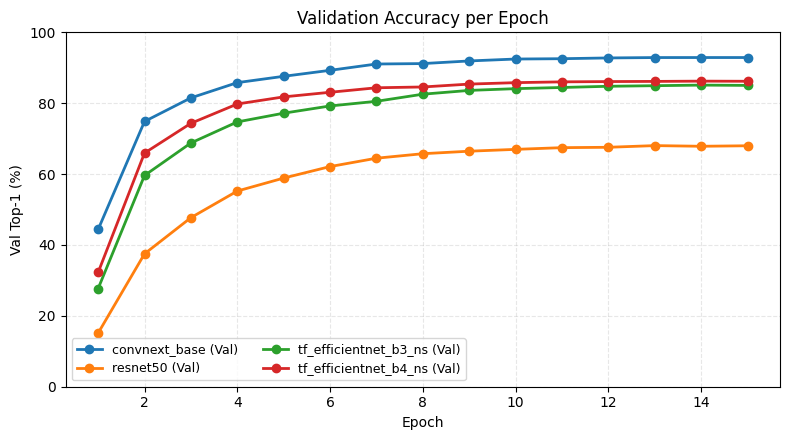

Saved: /content/celeba_data/visualization_graphs/line_val_top1_per_epoch.png


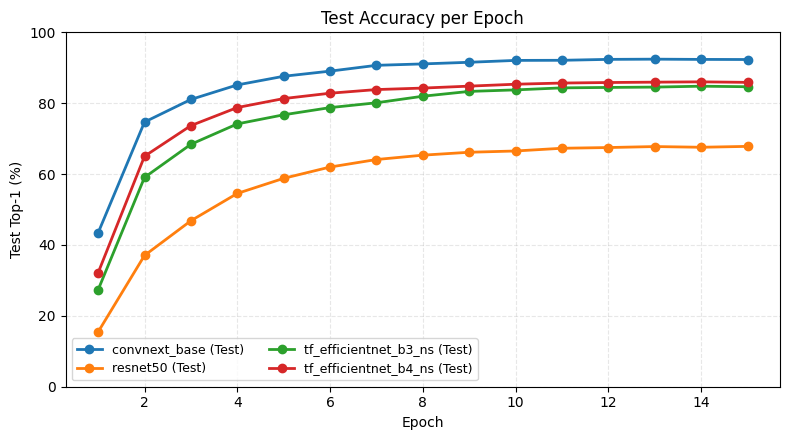

Saved: /content/celeba_data/visualization_graphs/line_test_top1_per_epoch.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

VIZ_DIR = Path("/content/celeba_data/visualization_graphs")
VIZ_DIR.mkdir(parents=True, exist_ok=True)

summary = RESULTS_SUMMARY[['Model', 'Val Top-1 (%)', 'Test Top-1 (%)']].copy()
summary = summary.sort_values('Test Top-1 (%)', ascending=False)
x = np.arange(len(summary)); w = 0.35

plt.figure(figsize=(8,4.5))
plt.bar(x - w/2, summary['Val Top-1 (%)'],  width=w, label='Val Top-1',  color='#46b3e6')
plt.bar(x + w/2, summary['Test Top-1 (%)'], width=w, label='Test Top-1', color='#f39c12')
plt.xticks(x, summary['Model'], rotation=20, ha='right')
plt.ylabel('Accuracy (%)'); plt.title('Final Accuracy by Model (Val vs Test)')
plt.ylim(0, 100); plt.grid(axis='y', linestyle='--', alpha=0.3); plt.legend(); plt.tight_layout()
bar_path = VIZ_DIR / "bar_final_val_vs_test_by_model.png"
plt.savefig(bar_path, dpi=200); plt.show()
print("Saved:", bar_path)

logs = EPOCH_LOGS.copy()
plt.figure(figsize=(8,4.5))
for m, g in logs.groupby('Model'):
    plt.plot(g['Epoch'], g['Val Top-1 (%)'], marker='o', linewidth=2, label=f'{m} (Val)')
plt.xlabel('Epoch'); plt.ylabel('Val Top-1 (%)'); plt.title('Validation Accuracy per Epoch')
plt.ylim(0, 100); plt.grid(True, linestyle='--', alpha=0.3); plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
line_val_path = VIZ_DIR / "line_val_top1_per_epoch.png"
plt.savefig(line_val_path, dpi=200); plt.show()
print("Saved:", line_val_path)

if 'Test Top-1 (%)' in logs.columns:
    plt.figure(figsize=(8,4.5))
    for m, g in logs.groupby('Model'):
        plt.plot(g['Epoch'], g['Test Top-1 (%)'], marker='o', linewidth=2, label=f'{m} (Test)')
    plt.xlabel('Epoch'); plt.ylabel('Test Top-1 (%)'); plt.title('Test Accuracy per Epoch')
    plt.ylim(0, 100); plt.grid(True, linestyle='--', alpha=0.3); plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    line_test_path = VIZ_DIR / "line_test_top1_per_epoch.png"
    plt.savefig(line_test_path, dpi=200); plt.show()
    print("Saved:", line_test_path)
else:
    print("EPOCH_LOGS has no 'Test Top-1 (%)' column; skipping test-per-epoch plot.")

In [ ]:
import os, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_label2id():
    if 'id2idx' in globals():
        inv = {v: int(k) for k, v in id2idx.items()}
        return inv
    assert 'train_df' in globals(), "train_df not found to rebuild label mapping."
    ids_sorted = sorted(train_df['celebrity_id'].unique())
    tmp_id2idx = {cid:i for i, cid in enumerate(ids_sorted)}
    inv = {v: int(k) for k, v in tmp_id2idx.items()}
    return inv

assert 'NUM_CLASSES' in globals(), "NUM_CLASSES not found. Run the split/build step first."

if 'label2id' not in globals():
    label2id = build_label2id()

assert set(label2id.keys()) == set(range(NUM_CLASSES)), \
    f"label2id keys {sorted(label2id.keys())[:5]}.. do not match 0..{NUM_CLASSES-1}"

assert 'RESULTS_SUMMARY' in globals(), "RESULTS_SUMMARY not found. Train first to populate it."
best_row = RESULTS_SUMMARY.sort_values("Test Top-1 (%)", ascending=False).iloc[0]
BEST_MODEL_NAME = best_row["Model"]
BEST_CKPT_PATH  = best_row.get("Checkpoint", "")
print(f"Using best backbone: {BEST_MODEL_NAME}")
if isinstance(BEST_CKPT_PATH, str) and BEST_CKPT_PATH:
    print(f"Checkpoint: {BEST_CKPT_PATH}")

if 'build_model' not in globals():
    import timm, torch.nn as nn
    class TimmClassifier(nn.Module):
        def __init__(self, name, num_classes, dropout=0.0):
            super().__init__()
            self.backbone = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
            f = self.backbone.num_features
            self.head = nn.Sequential(nn.LayerNorm(f), nn.Dropout(dropout), nn.Linear(f, num_classes))
        def forward(self, x, labels=None):
            feats = self.backbone(x)
            return self.head(feats)
    def build_model(name, num_classes, dropout=0.0):
        return TimmClassifier(name, num_classes, dropout).to(device)
    USE_ARCFACE = False

infer_model = build_model(BEST_MODEL_NAME, NUM_CLASSES, dropout=0.0).to(device)
infer_model.eval()

if isinstance(BEST_CKPT_PATH, str) and BEST_CKPT_PATH and os.path.exists(BEST_CKPT_PATH):
    ckpt = torch.load(BEST_CKPT_PATH, map_location=device)
    state_dict = ckpt.get('state_dict', ckpt)
    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = {k.replace('module.', '', 1): v for k,v in state_dict.items()}
    infer_model.load_state_dict(state_dict, strict=True)
else:
    print(" No checkpoint path found or file missing; using current weights.")

if 'test_tfms' in globals():
    infer_tfms = test_tfms
else:
    from torchvision import transforms
    infer_tfms = transforms.Compose([
        transforms.Resize(288),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

USE_ARCFACE = bool(globals().get('USE_ARCFACE', False))

@torch.no_grad()
def _forward_logits(x):
    try:
        return infer_model(x, labels=None) if USE_ARCFACE else infer_model(x)
    except TypeError:
        return infer_model(x)

@torch.no_grad()
def predict_image(img_path, topk=5, tta=True):
    img = Image.open(img_path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(device)
    if tta:
        x_flip = torch.flip(x, dims=[3])
        logits = (_forward_logits(x) + _forward_logits(x_flip)) * 0.5
    else:
        logits = _forward_logits(x)
    probs = F.softmax(logits, dim=1)[0]
    k = min(topk, NUM_CLASSES)
    top_p, top_i = probs.topk(k, dim=0)

    results = []
    for rank, (p, idx) in enumerate(zip(top_p.tolist(), top_i.tolist()), start=1):
        celeb_id = int(label2id[int(idx)])
        results.append({
            "rank": rank,
            "label_idx": int(idx),
            "celebrity_id": celeb_id,
            "prob": float(p),
        })
    return results

def show_preds(preds):
    for r in preds:
        print(f"{r['rank']}. celeb_id={r['celebrity_id']} (label {r['label_idx']}) — {100*r['prob']:.2f}%")

print("Inference ready")


Using best backbone: convnext_base
Checkpoint: /content/ckpts/best_convnext_base.pth
Inference ready


In [ ]:
import os, shutil
from google.colab import files

TEST_DIR = "/content/celeba_data/test_data"
os.makedirs(TEST_DIR, exist_ok=True)

uploaded = files.upload()
for fname, data in uploaded.items():
    dst = os.path.join(TEST_DIR, fname)
    with open(dst, "wb") as f:
        f.write(data)
    print("Saved ->", dst)

Saving aguero1.jpeg to aguero1.jpeg
Saving aguero2.jpeg to aguero2.jpeg
Saved -> /content/celeba_data/test_data/aguero1.jpeg
Saved -> /content/celeba_data/test_data/aguero2.jpeg


In [ ]:
img_path = "/content/celeba_data/test_data/aguero1.jpeg"
preds = predict_image(img_path, topk=5, tta=True)
show_preds(preds)

1. celeb_id=8656 (label 4347) — 99.64%
2. celeb_id=4891 (label 2505) — 0.13%
3. celeb_id=8659 (label 4350) — 0.09%
4. celeb_id=1448 (label 810) — 0.03%
5. celeb_id=8744 (label 4405) — 0.02%


In [ ]:
img_path = "/content/celeba_data/test_data/aguero2.jpeg"
preds = predict_image(img_path, topk=5, tta=True)
show_preds(preds)

1. celeb_id=8656 (label 4347) — 100.00%
2. celeb_id=8191 (label 4102) — 0.00%
3. celeb_id=7380 (label 3723) — 0.00%
4. celeb_id=3483 (label 1845) — 0.00%
5. celeb_id=7894 (label 3972) — 0.00%


In [ ]:
import shutil, os
from google.colab import files

BASE = "/content/celeba_data"
to_zip = [
    os.path.join(BASE, "test_data"),
    os.path.join(BASE, "visualization_graphs"),
]

zip_paths = []
for folder in to_zip:
    assert os.path.isdir(folder), f"Missing folder: {folder}"
    zip_path = f"/content/{os.path.basename(folder)}"
    shutil.make_archive(zip_path, "zip", folder)
    zip_paths.append(zip_path + ".zip")

for zp in zip_paths:
    print("Downloading:", zp)
    files.download(zp)


Downloading: /content/test_data.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/visualization_graphs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>